# Poisson process fit to start times

Import packages & configure plots for dark mode:

In [1]:
from preprocessing import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.ticker import FuncFormatter
plt.style.use("dark_background") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

Calculate and display the outliers in the rates:

In [2]:
rates = list(rates_dict.values())
cutoff = np.mean(rates) + 1.5*np.std(rates) # clearly nothing at minus 1.5sigma
max_rate = max(rates)
max_keys = [key for key, val in rates_dict.items() if val >= cutoff]
outliers = [get_station_name(i) for i in max_keys]
outliers

['Lexham Gardens, Kensington',
 'Queensway, Westminster',
 'Foley Street, Fitzrovia',
 'Marloes Road, Kensington',
 'Granby Street, Shoreditch',
 'South Quay East, Canary Wharf',
 'Devons Road, Bow',
 'Westminster Bridge Road, Elephant & Castle',
 'Shoreditch Court, Haggerston',
 'Belford House, Haggerston',
 'Temple Gardens, Temple']

In [3]:
np.mean(rates)

0.08087407157164574

Calculate the p-values for the different stations using the inter arrival times and the exponential distribution:

In [4]:
p_values = {}

for station in test_sorted_stations:
    station_id = station.start_id.unique()[0]
    rate = rates_dict[station_id]
    inter_arrival_times = station.start_time.diff().to_numpy() 
    inter_arrival_times[0] = station.start_time.to_numpy()[0] # change first inter-arrival time to t_1
    station_p_values = np.exp(-1* rate * inter_arrival_times)
    p_values[station_id] = station_p_values

p_values[1]

array([0.00000000e+00, 2.29304940e-11, 1.71785594e-01, 3.96403922e-03,
       2.75889555e-03, 7.61298813e-02, 3.21303383e-01, 5.14487471e-02,
       8.11378819e-04, 3.79620878e-07, 8.33061669e-03, 4.38694149e-01,
       9.29778217e-01, 9.61247110e-02, 2.29763658e-03, 3.81330441e-02,
       1.14663545e-12, 6.29606237e-17, 7.58156324e-01, 5.34722800e-01,
       1.88199121e-01, 5.26875481e-02, 4.06608114e-01, 2.92365674e-05,
       9.66200679e-01, 5.01375769e-01, 3.70065583e-02, 7.35746187e-01,
       8.22412515e-01, 1.60805628e-03, 1.46036274e-08, 5.26757327e-02,
       5.57565912e-02, 6.32964698e-01, 9.19465953e-01, 1.12577319e-01,
       5.38284478e-01, 1.03356115e-03, 2.46025219e-01, 2.29135608e-01,
       3.52996570e-19, 6.43917517e-04, 4.22087856e-05, 3.59953298e-01,
       1.96787789e-05, 2.96946256e-06, 1.90994827e-06, 4.91965107e-02,
       7.49449037e-01, 9.94986215e-01, 6.79917007e-01, 9.75698400e-01,
       2.30265349e-01, 3.22692142e-28, 9.32653892e-01, 8.71127670e-01,
      

Histogram of the p-values:

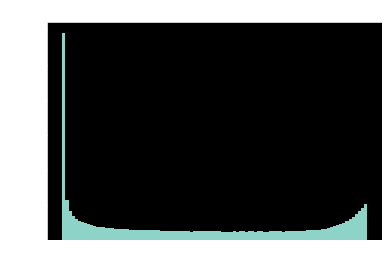

In [5]:
joined_p_values = np.concatenate(np.array(list(p_values.values()), dtype=object))
n, bins, patches = plt.hist(joined_p_values, bins=100)
ax = plt.gca()
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)
ax.yaxis.set_major_formatter(lblFormatter)
plt.title("Histogram of p-values for all stations")
plt.xlabel("P-value")
plt.ylabel("Counts (Thousands)")
plt.savefig("../figures/p-values.png")
plt.show()

Carry out and plot the Kolmogorov-Smirnov test on all the p-values to see if the poisson point process model is a good model for our data:

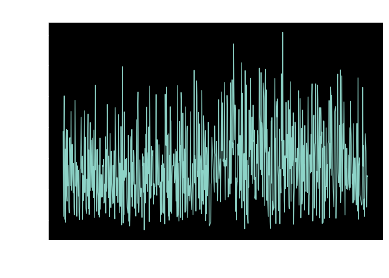

In [6]:
# Kolmogorov-smirnov:
kol_smir_test = {}
for station_id, pvals in p_values.items():
    kol_smir_test[station_id] = st.kstest(pvals, "uniform").statistic

plt.plot(kol_smir_test.keys(), kol_smir_test.values(), linewidth=0.7)
plt.title("Kolmogorov-Smirnov test for all stations")
plt.xlabel("Station Id")
plt.ylabel("$D_n$")
plt.savefig("../figures/kol-smir.png")
plt.show()

In [12]:
popularity_dict = {}
for station_id in p_values.keys():
    popularity_dict[station_id] = len(test_bike_data[test_bike_data.start_id == station_id])


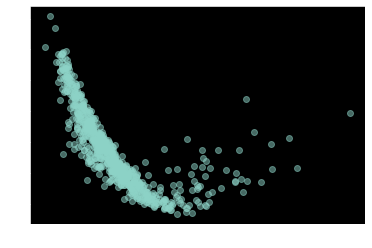

In [17]:
plt.scatter(popularity_dict.values(), kol_smir_test.values(), alpha=0.5)
plt.show()

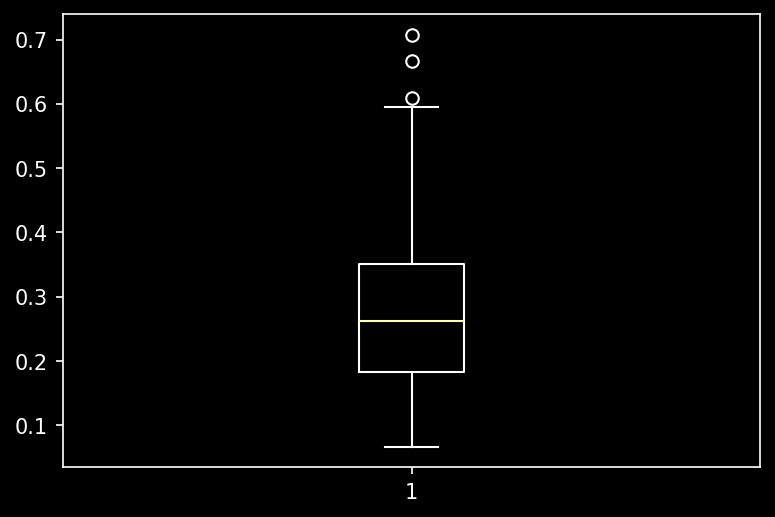

In [16]:
plt.boxplot(kol_smir_test.values())
plt.show()

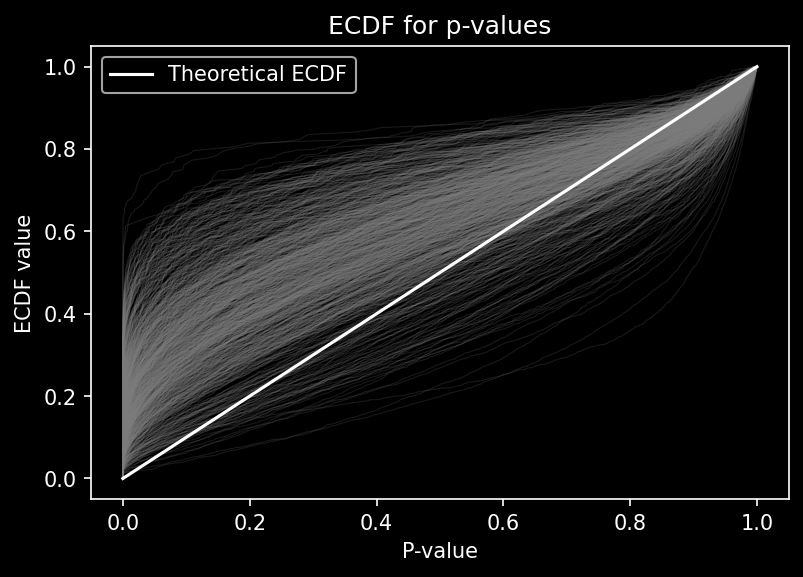

In [17]:
def ecdf(data): # https://cmdlinetips.com/2019/05/empirical-cumulative-distribution-function-ecdf-in-python/
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

for station, pvals in p_values.items():
    x,y = ecdf(pvals)
    plt.plot(x,y, alpha=0.2, linewidth=0.5, color="gray")

plt.title("ECDF for p-values")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], color="white", label="Theoretical ECDF")
plt.legend()
plt.show()